## Unsupervised Domain Adaptation by Backpropagation

## Source: Webcam | Target: DSLR

### 1. Import Libraries

In [1]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import plotly
import torch
from torch import nn
from torch.autograd import Function
from torch.nn import functional as F
from torch.optim import Adam, SGD
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import datasets, transforms
from torchvision.datasets import MNIST, ImageFolder
from torchvision.transforms import Compose, ToTensor
from torchvision.utils import make_grid
from plotly.subplots import make_subplots
from tqdm.notebook import tqdm

torch.manual_seed(42)
import matplotlib.pyplot as plt
from matplotlib import cm
import scipy.io as sio
import plotly.graph_objects as go
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
%matplotlib inline

# turn off torch cudnn backend
torch.backends.cudnn.enabled = False

In [2]:
BATCH_SIZE = 32
N_EPOCHS = 10
LR = 1e-3
OFFICE_PATH = "data/office"
SOURCE_MODEL_PATH = "models_office/webcam_source_model.pt"
TARGET_MODEL_PATH = "models_office/dslr_target_model.pt"
GRL_MODEL_PATH = "models_office/wd.pt"
IMG_SIZE = (256, 256)

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
def get_office_dataset(dname, splits=0.8):
    root_dir = f"{OFFICE_PATH}/{dname}/images"
    __datasets__ = ["amazon", "dslr", "webcam"]

    if dname not in __datasets__:
        raise ValueError("must introduce one of the three datasets in office")

    mean_std = {
        "amazon":{
            "mean":[0.7923, 0.7862, 0.7841],
            "std":[0.3149, 0.3174, 0.3193]
        },
        "dslr":{
            "mean":[0.4708, 0.4486, 0.4063],
            "std":[0.2039, 0.1920, 0.1996]
        },
        "webcam":{
            "mean":[0.6119, 0.6187, 0.6173],
            "std":[0.2506, 0.2555, 0.2577]
        }
    }

    data_transforms = transforms.Compose([
            transforms.Resize(IMG_SIZE),
            transforms.RandomCrop((224, 224)),
            transforms.ToTensor(),
            # transforms.Normalize(mean=mean_std[dname]["mean"],
            #                      std=mean_std[dname]["std"])
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])
        ])

    dataset = datasets.ImageFolder(root=root_dir,
                                   transform=data_transforms)

    train_size = int(splits * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size], torch.Generator().manual_seed(42))
    return train_dataset, test_dataset

In [4]:
amazon_train, amazon_test = get_office_dataset("amazon")
dslr_train, dslr_test = get_office_dataset("dslr")
webcam_train, webcam_test = get_office_dataset("webcam")

print(f"Amazon Train size: {len(amazon_train)}, test size: {len(amazon_test)}")
print(f"DSLR Train size: {len(dslr_train)}, test size: {len(dslr_test)}")
print(f"Webcam Train size: {len(webcam_train)}, test size: {len(webcam_test)}")

Amazon Train size: 2253, test size: 564
DSLR Train size: 398, test size: 100
Webcam Train size: 636, test size: 159


In [5]:
amazon_train_loader = DataLoader(amazon_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
amazon_test_loader = DataLoader(amazon_test, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

dslr_train_loader = DataLoader(dslr_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
dslr_test_loader = DataLoader(dslr_test, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

webcam_train_loader = DataLoader(webcam_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
webcam_test_loader = DataLoader(webcam_test, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

Amazon torch.Size([2253, 3, 224, 224]) torch.Size([2253])


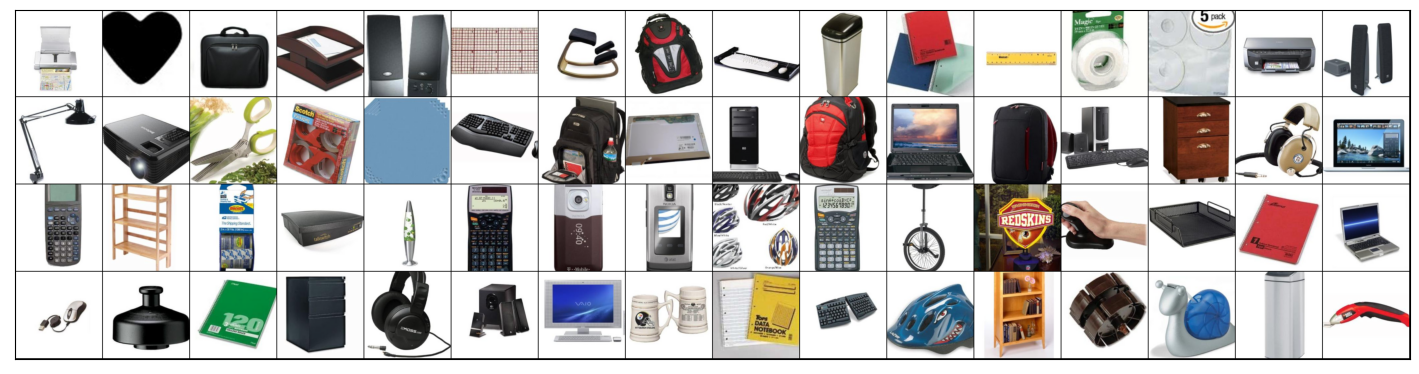

In [6]:
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

for images, labels in amazon_train_loader:
    print("Amazon", images.shape, labels.shape)
    fig, ax = plt.subplots(figsize=(18,10))
    ax.set_xticks([]); ax.set_yticks([])
    # images = images / 2 + 0.5
    images = inv_normalize(images)
    ax.imshow(make_grid(images[:64, :, :, :], nrow=16).permute(1,2,0))
    break

DSLR torch.Size([398, 3, 224, 224]) torch.Size([398])


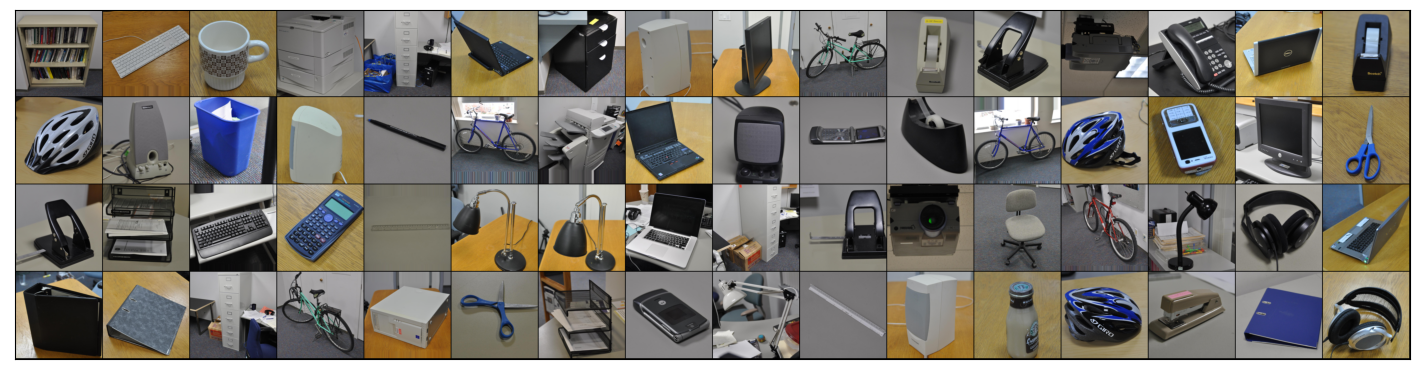

In [7]:
for images, labels in dslr_train_loader:
    print("DSLR", images.shape, labels.shape)
    fig, ax = plt.subplots(figsize=(18,10))
    ax.set_xticks([]); ax.set_yticks([])
    # images = images / 2 + 0.5
    images = inv_normalize(images)
    ax.imshow(make_grid(images[:64, :, :, :], nrow=16).permute(1,2,0))
    break

Webcam torch.Size([636, 3, 224, 224]) torch.Size([636])


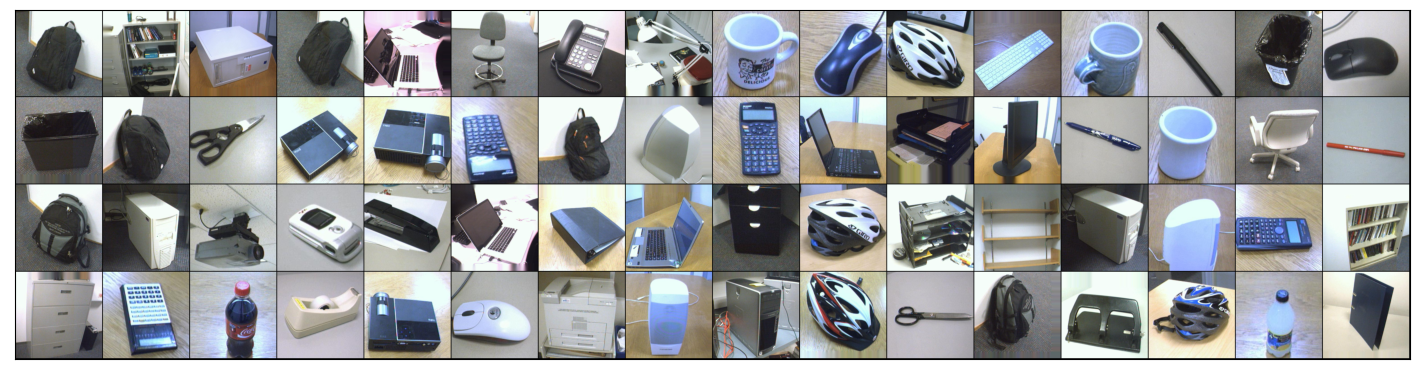

In [8]:
for images, labels in webcam_train_loader:
    print("Webcam", images.shape, labels.shape)
    fig, ax = plt.subplots(figsize=(18,10))
    ax.set_xticks([]); ax.set_yticks([])
    # images = images / 2 + 0.5
    images = inv_normalize(images)
    ax.imshow(make_grid(images[:64, :, :, :], nrow=16).permute(1,2,0))
    break

### 2. Train Source


In [6]:
class GradientReversalFunction(Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha
        return output, None

class Model(nn.Module):
    def __init__(self, grl=False):
        super().__init__()
        backbone = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
        # backbone.classifier[6] = nn.Linear(4096, 31, device=DEVICE)

        for param in list(backbone.parameters())[:8]:
            param.requires_grad = False

        self.feature_extractor = backbone.features
        # self.classifier = backbone.classifier

        # for param in backbone.classifier[6].parameters():
        #     param.requires_grad = True

        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(9216, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 1024),
            nn.ReLU(),
            nn.Linear(1024, 31)
        )
        
        self.domain_clf = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(9216, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 1024),
            nn.ReLU(),
            nn.Linear(1024, 1)
        )
        self.grl = grl

    def forward(self, x, alpha):
        features = self.feature_extractor(x)
        features = features.view(x.shape[0], -1)
        class_op = self.classifier(features)
        if self.grl:
            rev_feature = GradientReversalFunction.apply(features, alpha)
            domain_op = self.domain_clf(rev_feature)
            return class_op, domain_op
        return class_op

In [19]:
webcam_source_model = Model().to(DEVICE)

if os.path.exists(SOURCE_MODEL_PATH):
    webcam_source_model.load_state_dict(torch.load(SOURCE_MODEL_PATH))

webcam_source_optim = Adam(webcam_source_model.parameters(), lr=LR)
webcam_source_criterion = nn.CrossEntropyLoss()

Using cache found in /home/abhiroop.talasila/.cache/torch/hub/pytorch_vision_v0.10.0


In [8]:
def train(epoch, model, train_loader, criterion, optimizer):
    train_loss = 0
    model.train()
    tqdm_bar = tqdm(train_loader, desc=f'Training Epoch {epoch} ', total=int(len(train_loader)))
    for idx, (images, labels) in enumerate(tqdm_bar):
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(images, 0.)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_losses.append(loss.item())
        outputs = torch.argmax(outputs, dim=1).type(torch.FloatTensor).to(DEVICE)

        train_acc = accuracy_score(labels.cpu(), outputs.cpu())
        train_accs.append(train_acc)
        tqdm_bar.set_postfix(train_loss=(train_loss/(idx+1)), train_accuracy=train_acc)
        train_counter.append(idx * BATCH_SIZE + images.size(0) + epoch * len(train_loader.dataset))

def test(model, test_loader, criterion, name="source"):
    test_loss, test_acc = 0, 0
    model.eval()
    tqdm_bar = tqdm(test_loader, desc=f"Testing ", total=int(len(test_loader)))
    for idx, (images, labels) in enumerate(tqdm_bar):
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        with torch.no_grad():
            if name == "no1":
                outputs, _ = model(images, 1.)
            else:
                outputs = model(images, 0.)
            loss = criterion(outputs, labels)
        test_loss += loss.item()
        outputs = torch.argmax(outputs, dim=1).type(torch.FloatTensor).to(DEVICE)
            
        test_acc_b = accuracy_score(labels.cpu(), outputs.cpu())
        test_acc += test_acc_b
        tqdm_bar.set_postfix(test_loss=(test_loss/(idx+1)), test_accuracy=test_acc_b)
    test_losses.append(test_loss/len(test_loader))
    test_accs.append(test_acc/len(test_loader))
    if np.argmax(test_accs) == len(test_accs) - 1:
        torch.save(model.state_dict(), f"models_office/{name}_model.pt")

In [ ]:
train_losses, train_accs, train_counter = [], [], []
test_losses, test_accs = [], []
test_counter = [idx * len(webcam_train_loader.dataset) for idx in range(0, N_EPOCHS + 1)]

for epoch in range(N_EPOCHS):
    train(epoch, webcam_source_model, webcam_train_loader, webcam_source_criterion, webcam_source_optim)
    test(webcam_source_model, webcam_test_loader, webcam_source_criterion, name="webcam_source")

In [10]:
def plot_losses():
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=train_counter, y=train_losses, mode='lines', name='Train loss'))
    fig.add_trace(go.Scatter(x=test_counter, y=test_losses, marker_symbol='star-diamond', 
                            marker_color='orange', marker_line_width=1, marker_size=9, mode='markers', name='Test loss'))
    fig.update_layout(
        width=700, height=300,
        title="Train vs. Test Loss",
        xaxis_title="Number of training examples seen",
        yaxis_title="Negative Log Likelihood loss"),
    fig.show()

plot_losses() 

In [11]:
def plot_accs():
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=train_counter, y=train_accs, mode='lines', name='Train Accuracy'))
    fig.add_trace(go.Scatter(x=test_counter, y=test_accs, marker_symbol='star-diamond', 
                            marker_color='orange', marker_line_width=1, marker_size=9, mode='markers', name='Test Accuracy'))
    fig.update_layout(
        width=700, height=300,
        title="Train vs. Test Accuracy",
        xaxis_title="Number of training examples seen",
        yaxis_title="Accuracy")
    fig.show()

plot_accs()

In [25]:
test_losses, test_accs = [], []

webcam_source_model.load_state_dict(torch.load(SOURCE_MODEL_PATH))
test(webcam_source_model, dslr_test_loader, webcam_source_criterion, name="none")
print(f"Webcam source model accuracy on DSLR: {np.max(test_accs):.3f}")

Testing :   0%|          | 0/4 [00:00<?, ?it/s]

Webcam source model accuracy on DSLR: 0.922


### 3. Train Target

In [26]:
dslr_target_model = Model().to(DEVICE)

if os.path.exists(TARGET_MODEL_PATH):
    dslr_target_model.load_state_dict(torch.load(TARGET_MODEL_PATH))

dslr_target_optim = Adam(dslr_target_model.parameters(), lr=LR)
dslr_target_criterion = nn.CrossEntropyLoss()

Using cache found in /home/abhiroop.talasila/.cache/torch/hub/pytorch_vision_v0.10.0


In [ ]:
train_losses, train_accs, train_counter = [], [], []
test_losses, test_accs = [], []
test_counter = [idx * len(dslr_train_loader.dataset) for idx in range(0, N_EPOCHS + 1)]

for epoch in range(N_EPOCHS):
    train(epoch, dslr_target_model, dslr_train_loader, dslr_target_criterion, dslr_target_optim)
    test(dslr_target_model, dslr_test_loader, dslr_target_criterion, name="dslr_target")

In [28]:
plot_losses()

In [29]:
plot_accs()

In [32]:
test_losses, test_accs = [], []

dslr_target_model.load_state_dict(torch.load(TARGET_MODEL_PATH))
test(dslr_target_model, dslr_test_loader, dslr_target_criterion, name="none")
print(f"DSLR target model accuracy on DSLR: {np.max(test_accs):.3f}")

Testing :   0%|          | 0/4 [00:00<?, ?it/s]

DSLR target model accuracy on DSLR: 0.930


### 4. Train GRL

In [ ]:
grl_model = Model(grl=True).to(DEVICE)

In [34]:
half_batch = BATCH_SIZE // 2

source_train_loader = DataLoader(dslr_train, batch_size=half_batch, shuffle=True, num_workers=2)
source_test_loader = DataLoader(dslr_test, batch_size=BATCH_SIZE, shuffle=False)
target_train_loader = DataLoader(webcam_train, batch_size=half_batch, shuffle=True, num_workers=2)
target_test_loader = DataLoader(webcam_test, batch_size=BATCH_SIZE, shuffle=False)

In [35]:
N_EPOCHS = 30
LAMBDA = 10
LR_0 = 0.01
BETA = 0.75

def grl_train(model, strain_loader, ttrain_loader, stest_loader, ttest_loader, optimizer):
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    min_val_loss = np.Inf
    clf_criterion = nn.CrossEntropyLoss()
    dom_clf_criterion = nn.BCELoss()
    sigmoid = nn.Sigmoid()

    for epoch in range(N_EPOCHS):
        model.train()
        len_dataloader = min(len(strain_loader), len(ttrain_loader))
        pbar = tqdm(total=len_dataloader, leave=True, desc=f"Training Epoch {epoch}")
        curr_tloss, curr_vloss = 0., 0.

        source_iter, target_iter = iter(strain_loader), iter(ttrain_loader)

        for batch_idx in range(len_dataloader):
            source_data, source_labels = source_iter.__next__()
            target_data, target_labels = target_iter.__next__()
            
            p = float(batch_idx + epoch * len_dataloader) / (N_EPOCHS * len_dataloader)
            alpha = (2. / (1. + np.exp(-LAMBDA * p))) - 1
            for g in optimizer.param_groups:
                g["lr"] = LR_0 / np.power((1 + LAMBDA * p), BETA)
    
            source_data = source_data.to(DEVICE)
            source_labels = source_labels.to(DEVICE)
            target_data = target_data.to(DEVICE)
            target_labels = target_labels.to(DEVICE)
            source_domain_labels = torch.zeros(source_data.shape[0]).to(DEVICE)
            target_domain_labels = torch.ones(target_data.shape[0]).to(DEVICE)

            optimizer.zero_grad()

            # Predictions
            source_classes, source_domains = model(source_data, alpha)
            _, target_domains = model(target_data, alpha)

            # Losses
            label_loss = clf_criterion(source_classes, source_labels)
            source_domain_loss = dom_clf_criterion(sigmoid(
                source_domains[:, 0]), source_domain_labels)
            target_domain_loss = dom_clf_criterion(sigmoid(
                target_domains[:, 0]), target_domain_labels)
            
            loss = label_loss + source_domain_loss + target_domain_loss
            loss.backward()
            optimizer.step()
            curr_tloss += loss.cpu().data.item()
            
            # Accuracies
            y_true = target_domain_labels.cpu().detach().numpy()
            y_pred = sigmoid(target_domains[:, 0]).cpu().detach().numpy()
            y_pred = (y_pred >= 0.5) * 1.0
            domain_acc = accuracy_score(y_true, y_pred)

            y_true = source_labels.cpu().detach().numpy()
            y_pred = source_classes.max(1)[1].cpu().detach().numpy()
            label_acc = accuracy_score(y_true, y_pred)

            pbar.update(1)
            pbar.set_postfix(train_loss=loss.item(), domain_accuracy=domain_acc, 
                label_accuracy=label_acc)
            train_accs.append([domain_acc, label_acc])
            
        curr_tloss /= len_dataloader
        train_losses.append(curr_tloss)  
        
        model.eval()
        with torch.no_grad():
            len_val_dataloader = min(len(stest_loader), len(ttest_loader))
            source_val_iter, target_val_iter = iter(stest_loader), iter(ttest_loader)
            
            for _ in range(len_val_dataloader):
                source_val_data, source_val_labels = source_val_iter.__next__()
                target_val_data, target_val_labels = target_val_iter.__next__()

                source_val_data = source_val_data.to(DEVICE)
                source_val_labels = source_val_labels.to(DEVICE)
                target_val_data = target_val_data.to(DEVICE)
                target_val_labels = target_val_labels.to(DEVICE)
                
                source_pred_labels, _ = model(source_val_data, alpha)
                target_pred_labels, _ = model(target_val_data, alpha)

                source_label_loss = clf_criterion(source_pred_labels, source_val_labels)
                target_label_loss = clf_criterion(target_pred_labels, target_val_labels)
                
                loss = source_label_loss + target_label_loss
                curr_vloss += loss.cpu().data.item()

                source_acc = accuracy_score(source_val_labels.cpu().detach().numpy(), 
                                source_pred_labels.max(1)[1].cpu().detach().numpy())
                target_acc = accuracy_score(target_val_labels.cpu().detach().numpy(), 
                                target_pred_labels.max(1)[1].cpu().detach().numpy())

                val_acc = round((source_acc + target_acc) / 2, 3)
                val_accs.append(val_acc)
                
            curr_vloss /= len_val_dataloader
            val_losses.append(curr_vloss)

        if curr_vloss < min_val_loss:
            min_val_loss = curr_vloss
            torch.save(model.state_dict(), GRL_MODEL_PATH)

        pbar.set_postfix(train_loss=curr_tloss, domain_accuracy=domain_acc, 
            label_accuracy=label_acc, val_loss=curr_vloss, val_accuracy=val_acc)
        pbar.refresh()
        pbar.close()
    return train_losses, val_losses, train_accs, val_accs

In [ ]:
optimizer = SGD(grl_model.parameters(), lr=LR, momentum=0.9)

train_losses, test_losses, train_accs, val_accs = grl_train(grl_model, source_train_loader, target_train_loader, 
                                                        source_test_loader, target_test_loader, optimizer)

In [38]:
test_losses, test_accs = [], []
target_criterion = nn.CrossEntropyLoss()

grl_model.load_state_dict(torch.load(GRL_MODEL_PATH))
test(grl_model, webcam_test_loader, target_criterion, name="no1")
print(f"GRL model accuracy on DSLR: {np.max(test_accs):.3f}")

Testing :   0%|          | 0/5 [00:00<?, ?it/s]

GRL model accuracy on DSLR: 0.944


In [39]:
def evaluate(model, loader):
    preds_labels = []
    preds_domains = []
    gt_labels = []
    model.eval()

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(loader):
            data, target = data.to(DEVICE), target.to(DEVICE)
            pred_labels, pred_domains = model(data, 1.)
            pred_domains = np.round(np.array(pred_domains.cpu().detach()))
            preds_domains.append(pred_domains)
                
            softmax = torch.nn.Softmax()
            pred_labels = np.argmax(np.array(softmax(pred_labels.cpu().detach())), axis = 1)
            
            preds_labels.extend(pred_labels)
            gt_labels.extend(target.cpu())
    
    preds_labels = np.array(preds_labels)
    gt_labels = np.array(gt_labels)  
    return preds_labels, gt_labels

In [40]:
grl_preds, grl_gt = evaluate(grl_model, webcam_test_loader)

print("Class Label Report")
print(classification_report(grl_preds, grl_gt))

Class Label Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         6
           3       1.00      0.67      0.80         3
           4       1.00      1.00      1.00         3
           5       0.50      1.00      0.67         3
           6       1.00      1.00      1.00         4
           7       1.00      1.00      1.00         3
           8       1.00      1.00      1.00         4
           9       0.67      1.00      0.80         2
          10       1.00      1.00      1.00         6
          11       1.00      1.00      1.00         6
          12       1.00      1.00      1.00         2
          13       1.00      1.00      1.00         3
          14       1.00      0.75      0.86         8
          15       1.00      0.89      0.94         9
          16       1.00      1.00      1.00         8
        

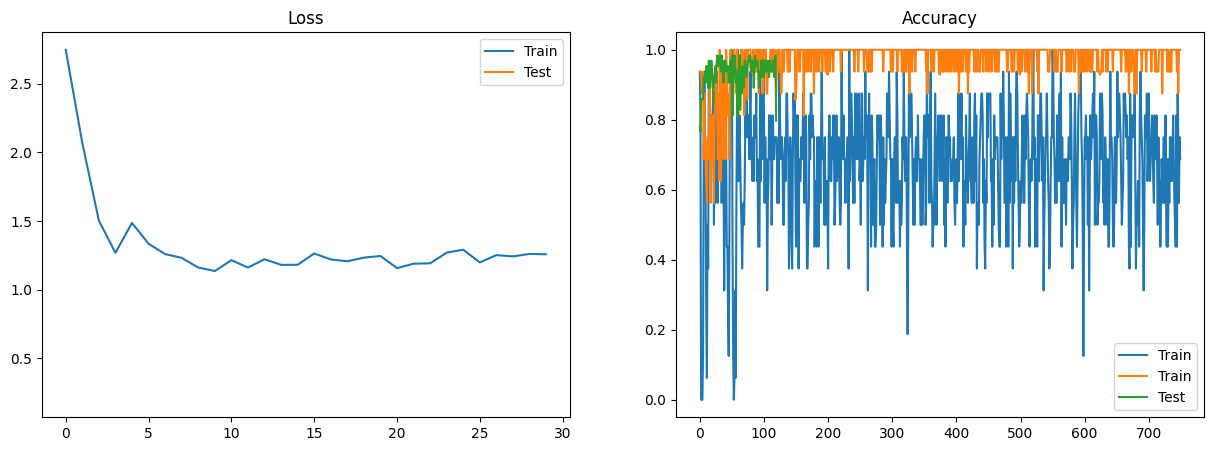

In [41]:
# plot loss curves using train_losses, test_losses

f, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(train_losses, label="Train")
ax[0].plot(test_losses, label="Test")
ax[0].set_title("Loss")
ax[0].legend()
ax[1].plot(train_accs, label="Train")
ax[1].plot(val_accs, label="Test")
ax[1].set_title("Accuracy")
ax[1].legend()
plt.show()

### 5. TSNE

In [42]:
def tsne_features(model, sloader, tloader, subset=1500):
    model.eval()
    model = model.to(DEVICE)
    sfeats, tfeats = [], []
    
    for _, (data, _) in enumerate(sloader):
        data = data.to(DEVICE)
        feats = model.feature_extractor(data).cpu().detach().numpy()
        sfeats.append(feats)

    for _, (data, _) in enumerate(tloader):
        data = data.to(DEVICE)
        feats = model.feature_extractor(data).cpu().detach().numpy()
        tfeats.append(feats)

    sfeats = np.vstack(np.array(sfeats))[:subset, :]
    tfeats = np.vstack(np.array(tfeats))[:subset, :]

    sfeats = sfeats.reshape(sfeats.shape[0], -1)
    tfeats = tfeats.reshape(tfeats.shape[0], -1)

    tsne = TSNE(n_components=2, random_state=42, init="pca")
    tsne_proj_source = tsne.fit_transform(sfeats)
    tsne_proj_target = tsne.fit_transform(tfeats)
    return tsne_proj_source, tsne_proj_target
    

In [43]:
s_sproj, s_tproj = tsne_features(webcam_source_model, webcam_test_loader, dslr_test_loader)
t_sproj, t_tproj = tsne_features(dslr_target_model, webcam_test_loader, dslr_test_loader)
g_sproj, g_tproj = tsne_features(grl_model, webcam_test_loader, dslr_test_loader)

In [46]:
# there was an outlier which was messing up the TSNE plot

max_x, idx = -1, 0
for i, x in enumerate(s_sproj):
    if x[0] > max_x:
        max_x = x[0]
        idx = i

s_new = np.delete(s_sproj, i, 0)

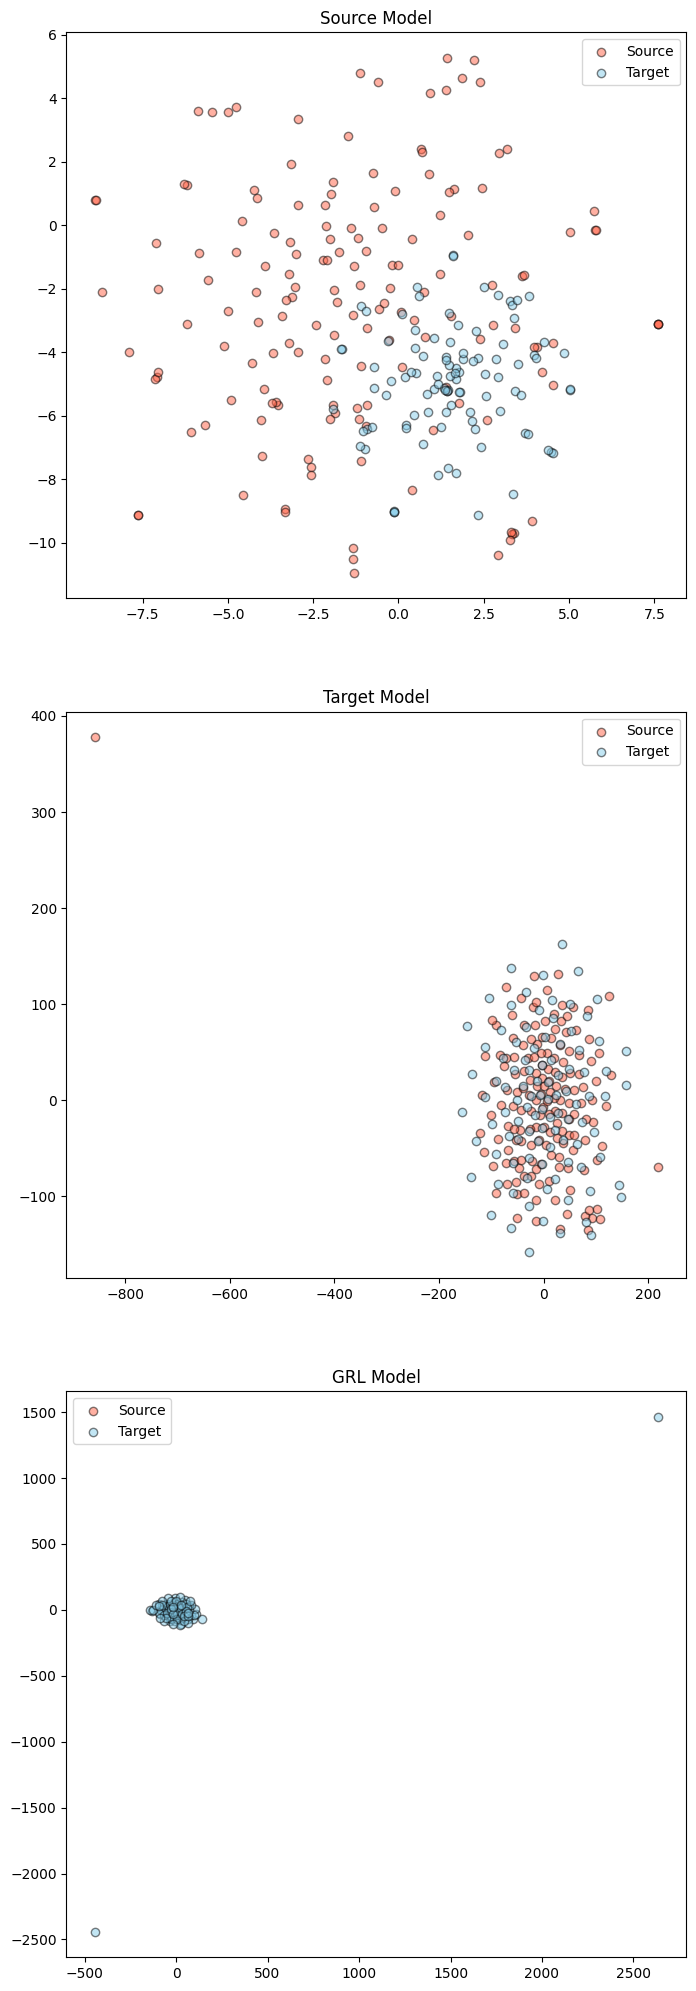

In [44]:
f, ax = plt.subplots(3, 1, figsize=(8, 25))
cmap = cm.get_cmap("tab20")
s_projs = [s_sproj, t_sproj, g_sproj]
t_projs = [s_tproj, t_tproj, g_tproj]

for i, title in zip([0, 1, 2], ["Source", "Target", "GRL"]):
    ax[i].scatter(s_projs[i][:, 0], s_projs[i][:, 1], c="tomato", label="Source", alpha=0.5, edgecolors='black')
    ax[i].scatter(t_projs[i][:, 0], t_projs[i][:, 1], c="skyblue", label="Target", alpha=0.5, edgecolors='black')
    ax[i].set_title(f"{title} Model")
    ax[i].legend()
plt.show()